In [1]:
import torch
import torch.nn as nn

In [2]:
class ConvolutionalBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        is_downsampling: bool = True,
        add_activation: bool = True,
        **kwargs
    ):
        super().__init__()
        if is_downsampling:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )
        else:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )

    def forward(self, x):
        return self.conv(x)

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        """
        In a residual block, the use of two ConvBlock instances with one having
        an activation function and the other not is a design choice that promotes
        the learning of residual information.

        The purpose of a residual block is to learn the residual mapping between
        the input and output of the block. The first ConvBlock in the sequence,
        which includes an activation function, helps in capturing and extracting
        important features from the input. The activation function introduces
        non-linearity, allowing the network to model complex relationships
        between the input and output.

        The second ConvBlock does not include an activation function.
        It mainly focuses on adjusting the dimensions (e.g., number of channels)
        of the features extracted by the first ConvBlock. The absence of an
        activation function in the second ConvBlock allows the block to learn
        the residual information. By directly adding the output of the second
        ConvBlock to the original input, the block learns to capture the
        residual features or changes needed to reach the desired output.

        (Information and explanation above generated by ChatGPT)
        """
        super().__init__()
        self.block = nn.Sequential(
            ConvolutionalBlock(channels, channels, add_activation=True, kernel_size=3, padding=1),
            ConvolutionalBlock(channels, channels, add_activation=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        """
        This skip connection, achieved through the addition operation, helps
        in propagating gradients during training and alleviates the vanishing
        gradient problem. It also facilitates the flow of information from earlier
        layers to later layers, allowing the network to learn more effectively.

        (Information and explanation above generated by ChatGPT)
        """
        return x + self.block(x)

In [4]:
class Generator(nn.Module):
    def __init__(
        self, img_channels: int, num_features: int = 64, num_residuals: int = 9
    ):
        """
        Generator consists of 2 layers of downsampling/encoding layer,
        followed by 9 residual blocks for 128 × 128 training images
        and then 3 upsampling/decoding layer.

        The network with 6 residual blocks can be written as:
        c7s1–64, d128, d256, R256, R256, R256, R256, R256, R256, u128, u64, and c7s1–3.

        The network with 9 residual blocks consists of:
        c7s1–64, d128, d256, R256, R256, R256, R256, R256, R256, R256, R256, R256, u128, u64, and c7s1–3.
        """
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.ReLU(inplace=True),
        )

        self.downsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features,
                    num_features * 2,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 4,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )

        self.residual_layers = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )

        self.upsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features * 4,
                    num_features * 2,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 1,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last_layer = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial_layer(x)
        for layer in self.downsampling_layers:
            x = layer(x)
        x = self.residual_layers(x)
        for layer in self.upsampling_layers:
            x = layer(x)
        return torch.tanh(self.last_layer(x))

In [5]:
class ConvInstanceNormLeakyReLUBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        """
        Class object initialization for Convolution-InstanceNorm-LeakyReLU layer

        We use leaky ReLUs with a slope of 0.2.
        """
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=4,
                stride=stride,
                padding=1,
                bias=True,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [6]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        """
        Let Ck denote a 4 × 4 Convolution-InstanceNorm-LeakyReLU layer with
        k filters and stride 2. Discriminator architecture is: C64-C128-C256-C512.

        After the last layer, we apply a convolution to produce a 1-dimensional
        output.

        We use leaky ReLUs with a slope of 0.2.
        """
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                ConvInstanceNormLeakyReLUBlock(
                    in_channels,
                    feature,
                    stride=1 if feature == features[-1] else 2,
                )
            )
            in_channels = feature

        # After the last layer, we apply a convolution to produce a 1-dimensional output
        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_layer(x)

        # feed the model output into a sigmoid function to make a 1/0 label
        return torch.sigmoid(self.model(x))

In [7]:
import torch
from PIL import Image
import os
from torch.utils.data import Dataset
import numpy as np
import torchvision.transforms as T

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {DEVICE}")

TRAIN_DIR = '../dataset/train_test'
VAL_DIR = '../dataset/train_test'

BATCH_SIZE = 32
LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 0.0 # loss weight for identity loss
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS = 50

LOAD_MODEL = True
SAVE_MODEL = True

CHECKPOINT_GENERATOR_H = "models/genh.pth.tar"
CHECKPOINT_GENERATOR_Z = "models/genz.pth.tar"
CHECKPOINT_DISCRIMINATOR_H = "models/disch.pth.tar"
CHECKPOINT_DISCRIMINATOR_Z = "models/discz.pth.tar"

using device: cuda


In [8]:
import random, torch, os, numpy as np
import torch.nn as nn
import copy

def save_checkpoint(model, optimizer, filename="models/checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [9]:
import torch
import sys
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image

def train_fn(disc_H, disc_Z, gen_Z, gen_H, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler):
    H_reals = 0
    H_fakes = 0
    loop = tqdm(loader, leave=True)

    for idx, (zebra, horse) in enumerate(loop):
        zebra = zebra.to(DEVICE)
        horse = horse.to(DEVICE)

        # Train discriminators H and Z
        with torch.cuda.amp.autocast():
            fake_horse = gen_H(zebra)
            D_H_real = disc_H(horse)
            D_H_fake = disc_H(fake_horse.detach())
            H_reals += D_H_real.mean().item()
            H_fakes += D_H_fake.mean().item()
            D_H_real_loss = mse(D_H_real, torch.ones_like(D_H_real))
            D_H_fake_loss = mse(D_H_fake, torch.zeros_like(D_H_fake))
            D_H_loss = D_H_real_loss + D_H_fake_loss

            fake_zebra = gen_Z(horse)
            D_Z_real = disc_Z(zebra)
            D_Z_fake = disc_Z(fake_zebra.detach())
            D_Z_real_loss = mse(D_Z_real, torch.ones_like(D_Z_real))
            D_Z_fake_loss = mse(D_Z_fake, torch.zeros_like(D_Z_fake))
            D_Z_loss = D_Z_real_loss + D_Z_fake_loss

            D_loss = (D_H_loss + D_Z_loss) / 2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generators H and Z
        with torch.cuda.amp.autocast():
            # adversarial losses
            D_H_fake = disc_H(fake_horse)
            D_Z_fake = disc_Z(fake_zebra)
            loss_G_H = mse(D_H_fake, torch.ones_like(D_H_fake))
            loss_G_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake))

            # cycle losses
            cycle_zebra = gen_Z(fake_horse)
            cycle_horse = gen_H(fake_zebra)
            cycle_zebra_loss = l1(zebra, cycle_zebra)
            cycle_horse_loss = l1(horse, cycle_horse)

            # identity losses
            # identity_zebra = gen_Z(zebra)
            # identity_horse = gen_H(horse)
            # identity_zebra_loss = l1(zebra, identity_zebra)
            # identity_horse_loss = l1(horse, identity_horse)

            # total loss
            G_loss = (
                loss_G_Z
                + loss_G_H
                + cycle_zebra_loss * LAMBDA_CYCLE
                + cycle_horse_loss * LAMBDA_CYCLE
                # + identity_horse_loss * LAMBDA_IDENTITY
                # + identity_zebra_loss * LAMBDA_IDENTITY
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 200 == 0:
            save_image(fake_horse * 0.5 + 0.5, f"outputs/horse_{idx}.png")
            save_image(fake_zebra * 0.5 + 0.5, f"outputs/zebra_{idx}.png")

        loop.set_postfix(H_real=H_reals / (idx + 1), H_fake=H_fakes / (idx + 1))

In [10]:
disc_H = Discriminator(in_channels=3).to(DEVICE)
disc_Z = Discriminator(in_channels=3).to(DEVICE)
gen_Z = Generator(img_channels=3, num_residuals=9).to(DEVICE)
gen_H = Generator(img_channels=3, num_residuals=9).to(DEVICE)

# use Adam Optimizer for both generator and discriminator
opt_disc = optim.Adam(
    list(disc_H.parameters()) + list(disc_Z.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

opt_gen = optim.Adam(
    list(gen_Z.parameters()) + list(gen_H.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

L1 = nn.L1Loss()
mse = nn.MSELoss()

In [11]:
if LOAD_MODEL:
    load_checkpoint(
        CHECKPOINT_GENERATOR_H,
        gen_H,
        opt_gen,
        LEARNING_RATE,
    )
    load_checkpoint(
        CHECKPOINT_GENERATOR_Z,
        gen_Z,
        opt_gen,
        LEARNING_RATE,
    )
    load_checkpoint(
        CHECKPOINT_DISCRIMINATOR_H,
        disc_H,
        opt_disc,
        LEARNING_RATE,
    )
    load_checkpoint(
        CHECKPOINT_DISCRIMINATOR_Z,
        disc_Z,
        opt_disc,
        LEARNING_RATE,
    )

=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint


In [12]:
transforms = T.Compose(
    [
        T.Resize((256,256)),
        T.RandomHorizontalFlip(p=0.5),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
)

In [13]:
from MangaDataset import MangaDataset

loader = DataLoader(MangaDataset(VAL_DIR, transforms_=transforms), 
                        batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

In [14]:
DO_TRAIN = False 
if DO_TRAIN :
    for epoch in range(NUM_EPOCHS):
        train_fn(
            disc_H, disc_Z, gen_Z, gen_H,
            loader,
            opt_disc,
            opt_gen,
            L1,
            mse,
            d_scaler,
            g_scaler,
        )

        if SAVE_MODEL:
            save_checkpoint(gen_H, opt_gen, filename=CHECKPOINT_GENERATOR_H)
            save_checkpoint(gen_Z, opt_gen, filename=CHECKPOINT_GENERATOR_Z)
            save_checkpoint(disc_H, opt_disc, filename=CHECKPOINT_DISCRIMINATOR_H)
            save_checkpoint(disc_Z, opt_disc, filename=CHECKPOINT_DISCRIMINATOR_Z)

In [15]:
if DO_TRAIN :
    torch.save(disc_H.state_dict(), 'models/model_gray_to_color.pth')
    torch.save(disc_Z.state_dict(), 'models/model_color_to_gray.pth')
    torch.save(gen_Z.state_dict(), 'models/model_color_d.pth')
    torch.save(gen_H.state_dict(), 'models/model_gray_d.pth')

In [16]:
val_loader = DataLoader(MangaDataset(VAL_DIR, transforms_=transforms), 
                        batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

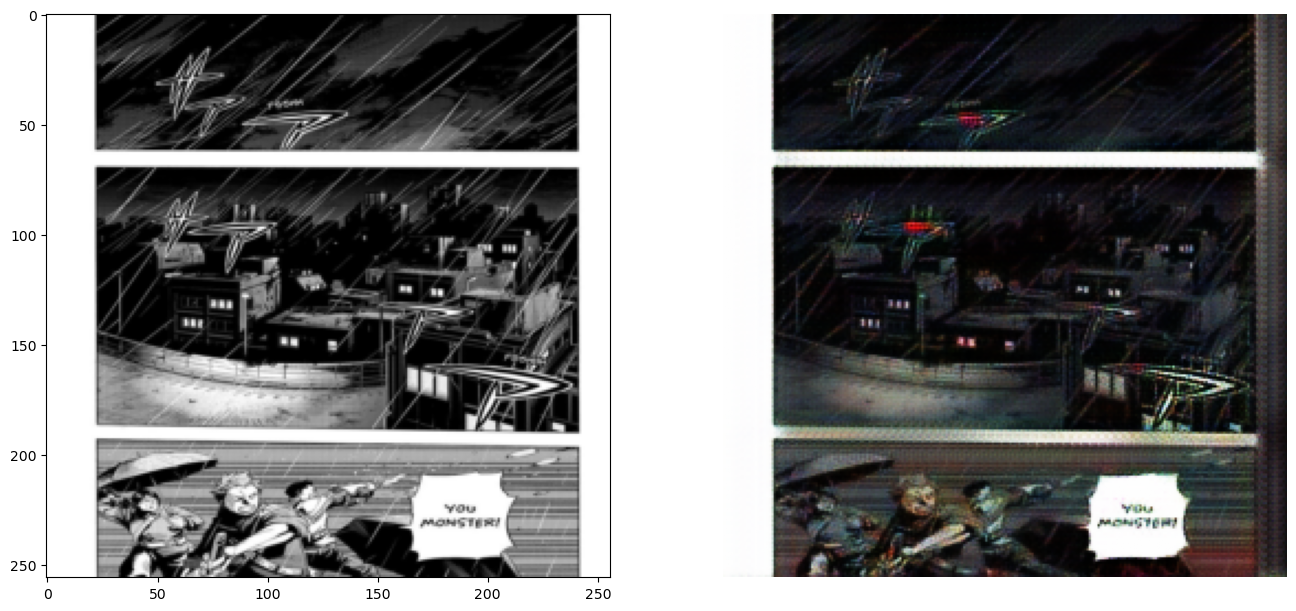

In [17]:
import matplotlib.pyplot as plt
from PIL import Image

data_iterator = iter(val_loader)
first_batch = next(data_iterator)

zebra, horse = first_batch
#zebra = zebra.to(DEVICE)
horse = horse.to(DEVICE)

#     fake_horse = gen_H(zebra)
fake_zebra = gen_Z(horse)

#     save_image(fake_horse * 0.5 + 0.5, f"outputs/horse_{idx}.png")
#     save_image(fake_zebra * 0.5 + 0.5, f"outputs/zebra_{idx}.png")

horse = horse * 0.5 + 0.5
fake_zebra = fake_zebra * 0.5 + 0.5

fake_horse_pil = T.ToPILImage()(horse[0])
fake_zebra_pil = T.ToPILImage()(fake_zebra[0])

# Load image as a tensor
loader = T.Compose([T.ToTensor()])  # Converts image to tensor
horse_tensor = loader(fake_horse_pil).unsqueeze(0)  # Add batch dimension
zebra_tensor = loader(fake_zebra_pil).unsqueeze(0)  # Add batch dimension

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

# Display the image tensor
axes[0].imshow(horse_tensor.squeeze().permute(1, 2, 0))  # Permute dimensions for correct display
axes[1].imshow(zebra_tensor.squeeze().permute(1, 2, 0))  # Permute dimensions for correct display
plt.axis('off')
plt.show()
